# Perform a LCOH analysis for an onshore wind + Hydrogen PEM system

### Load necessary modules

In [17]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
import os
import sys
sys.path.append('')
from dotenv import load_dotenv
import pandas as pd
import json
from hopp.sites import SiteInfo
from hopp.sites import flatirons_site as sample_site
from hopp.keys import set_developer_nrel_gov_key
# from plot_reopt_results import plot_reopt_results
# from run_reopt import run_reopt
from examples.H2_Analysis.hopp_for_h2 import hopp_for_h2
from examples.H2_Analysis.run_h2a import run_h2a as run_h2a
from examples.H2_Analysis.simple_dispatch import SimpleDispatch
import examples.H2_Analysis.run_h2_PEM as run_h2_PEM
import numpy as np
import numpy_financial as npf
from lcoe.lcoe import lcoe as lcoe_calc
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set API key

In [18]:
load_dotenv()
NREL_API_KEY = os.getenv("NREL_API_KEY")
set_developer_nrel_gov_key(NREL_API_KEY)  # Set this key manually here if you are not setting it using the .env


### Create output dictionary

In [19]:
def establish_save_output_dict():
    """
    Establishes and returns a 'save_outputs_dict' dict
    for saving the relevant analysis variables for each site.
    """

    save_outputs_dict = dict()
    save_outputs_dict['Site Name'] = list()
    save_outputs_dict['Scenario Choice'] = list()
    save_outputs_dict['Site Lat'] = list()
    save_outputs_dict['Site Lon'] = list()
    save_outputs_dict['ATB Year'] = list()
    save_outputs_dict['Resource Year'] = list()
    save_outputs_dict['Critical Load Factor'] = list()
    save_outputs_dict['kW continuous load'] = list()
    save_outputs_dict['Useful Life'] = list()
    save_outputs_dict['PTC'] = list()
    save_outputs_dict['ITC'] = list()
    save_outputs_dict['Discount Rate'] = list()
    save_outputs_dict['Debt Equity'] = list()
    save_outputs_dict['Hub Height (m)'] = list()
    save_outputs_dict['Storage Enabled'] = list()
    save_outputs_dict['Wind Cost kW'] = list()
    save_outputs_dict['Solar Cost kW'] = list()
    save_outputs_dict['Storage Cost kW'] = list()
    save_outputs_dict['Storage Cost kWh'] = list()
    save_outputs_dict['Storage Hours'] = list()
    save_outputs_dict['Wind MW built'] = list()
    save_outputs_dict['Solar MW built'] = list()
    save_outputs_dict['Storage MW built'] = list()
    save_outputs_dict['Storage MWh built'] = list()
    save_outputs_dict['Electrolyzer Size'] = list()
    save_outputs_dict['Electrolyzer Total System Size'] = list()
    save_outputs_dict['Battery Can Grid Charge'] = list()
    save_outputs_dict['Grid Connected HOPP'] = list()
    save_outputs_dict['Built Interconnection Size'] = list()
    save_outputs_dict['Total Installed Cost $(HOPP)'] = list()
    save_outputs_dict['Total Yearly Electrical Output'] = list()
    save_outputs_dict['LCOE'] = list()
    save_outputs_dict['Total Annual H2 production (kg)'] = list()
    save_outputs_dict['Gut-Check Cost/kg H2 (non-levelized, includes elec if used)'] = list()
    save_outputs_dict['Levelized Cost/kg H2 (lcoe using installed and operation costs)'] = list()
    save_outputs_dict['Levelized Cost/kg H2 (CF Method - using annual cashflows per technology)'] = list()
    save_outputs_dict['H2A scaled total install cost'] = list()
    save_outputs_dict['H2A scaled total install cost per kw'] = list()
    save_outputs_dict['HOPP Total Generation'] = list()
    save_outputs_dict['Wind Capacity Factor'] = list()
    save_outputs_dict['HOPP Energy Shortfall'] = list()
    save_outputs_dict['HOPP Curtailment'] = list()
    save_outputs_dict['Battery Generation'] = list()
    save_outputs_dict['Electricity to Grid'] = list()
    
    return save_outputs_dict

# Step 1: Establish output structure and special inputs

In [20]:
# save_all_runs = pd.DataFrame()
save_outputs_dict = establish_save_output_dict()
year = 2013
sample_site['year'] = year
useful_life = 30
critical_load_factor = 1
run_reopt_flag = False
custom_powercurve = True
storage_used = True
battery_can_grid_charge = False
grid_connected_hopp = False
interconnection_size_mw = 100
electrolyzer_size = 100

# which plots to show
plot_power_production = True
plot_battery = True
plot_grid = True
plot_h2 = True
# plot_reopt = True

# Step 2: Load scenarios from .csv and enumerate

In [21]:
# scenarios_df = pd.read_csv('H2 Baseline Future Scenarios Test Refactor.csv')
# Please note that one scenario where __file__ has advantage is when you are invoking python from directory A but running script in directory B. In that case above as well as most other methods will return A, not B. However for Jupyter notbook, you always get folder for .ipyn file instead of the directory from where you launched jupyter notebook.
#parent_path = os.path.abspath(os.path.dirname(__file__))

parent_path = os.path.abspath('')
print(parent_path)
scenarios_df = pd.read_csv(os.path.join(parent_path,'examples/H2_Analysis/default_h2_scenarios.csv'))
scenarios_df

/Users/abarker/Desktop/Hybrid Model/Code/HOPP_Private


,Scenario Number,Scenario Name,Site Name,Force Plant Size,Force Electrolyzer Cost,Wind Size MW,Solar Size MW,Storage Size MW,Storage Size MWh,Lat,...,Turbine Rating,Tower Height,Rotor Diameter,Wind Cost KW,Solar Cost KW,Storage Cost KW,Storage Cost KWh,Electrolyzer Cost KW,Buy From Grid ($/kWh),Sell To Grid ($/kWh)
0,1,2030 Conservative,TexasTest,True,True,100,1,1,1,36.103,...,7,110,150,958,598,97,104,100,False,False
1,2,2030 Moderate,Georgia,True,True,100,1,1,1,33.162,...,7,120,175,910,598,97,104,100,False,False
2,3,2030 Advanced,Georgia,True,True,100,1,1,1,33.162,...,7,135,200,671,598,97,104,100,False,False
3,1,2030 Conservative,Georgia,True,True,100,1,1,1,33.162,...,7,110,150,958,598,97,104,100,False,False
4,2,2030 Moderate,Georgia,True,True,100,1,1,1,33.162,...,7,120,175,910,598,97,104,100,False,False
5,3,2030 Advanced,Georgia,True,True,100,1,1,1,33.162,...,7,135,200,671,598,97,104,100,False,False


# Step 3: Assign Scenario Details from file

In [22]:
for i, scenario in scenarios_df.iterrows():
    kw_continuous = electrolyzer_size * 1000
    load = [kw_continuous for x in
            range(0, 8760)]  # * (sin(x) + pi) Set desired/required load profile for plant

    scenario_choice = scenario['Scenario Name']
    site_name = scenario['Site Name']
    sample_site['lat'] = scenario['Lat']
    sample_site['lon'] = scenario['Long']
    lat = scenario['Lat']
    lon = scenario['Long']
    atb_year = scenario['ATB Year']
    ptc_avail = scenario['PTC Available']
    itc_avail = scenario['ITC Available']
    forced_sizes = scenario['Force Plant Size']
    force_electrolyzer_cost = scenario['Force Electrolyzer Cost']
    if forced_sizes:
        forced_wind_size = scenario['Wind Size MW']
        forced_solar_size = scenario['Solar Size MW']
        forced_storage_size_mw = scenario['Storage Size MW']
        forced_storage_size_mwh = scenario['Storage Size MWh']
    else:
        print("Using ReOPT for sizing. REopt will be turned on and may not find a solution")
        run_reopt_flag = True

    if force_electrolyzer_cost:
        forced_electrolyzer_cost = scenario['Electrolyzer Cost KW']

    tower_height = scenario['Tower Height']
    rotor_diameter = scenario['Rotor Diameter']
    turbine_rating = scenario['Turbine Rating']
    wind_cost_kw = scenario['Wind Cost KW']
    custom_powercurve_path = scenario['Powercurve File']
    solar_cost_kw = scenario['Solar Cost KW']
    storage_cost_kw = scenario['Storage Cost KW']
    storage_cost_kwh = scenario['Storage Cost KWh']
    debt_equity_split = scenario['Debt Equity']

    buy_price = scenario['Buy From Grid ($/kWh)']
    sell_price = scenario['Sell To Grid ($/kWh)']

    #Todo: Add useful life to .csv scenario input instead
    scenario['Useful Life'] = useful_life

    site = SiteInfo(sample_site, hub_height=tower_height)

# Step 4: Set up HOPP run

In [23]:
if forced_sizes:
    solar_size_mw = forced_solar_size
    wind_size_mw = forced_wind_size
    storage_size_mw = forced_storage_size_mw
    storage_size_mwh = forced_storage_size_mwh
    storage_hours = 0


technologies = {'pv':
                    {'system_capacity_kw': solar_size_mw * 1000},
                'wind':
                    {'num_turbines': np.floor(scenario['Wind Size MW'] / scenario['Turbine Rating']),
                        'turbine_rating_kw': scenario['Turbine Rating']*1000,
                        'hub_height': scenario['Tower Height'],
                        'rotor_diameter': scenario['Rotor Diameter']},
                'battery': {
                    'system_capacity_kwh': storage_size_mwh * 1000,
                    'system_capacity_kw': storage_size_mw * 1000
                    }
                }

hybrid_plant, combined_pv_wind_power_production_hopp, combined_pv_wind_curtailment_hopp,\
energy_shortfall_hopp, annual_energies, wind_plus_solar_npv, npvs, lcoe =  \
    hopp_for_h2(site, scenario, technologies,
                wind_size_mw, solar_size_mw, storage_size_mw, storage_size_mwh, storage_hours,
    wind_cost_kw, solar_cost_kw, storage_cost_kw, storage_cost_kwh,
    kw_continuous, load,
    custom_powercurve,
    electrolyzer_size, grid_connected_hopp=True)

wind_installed_cost = hybrid_plant.wind.total_installed_cost
solar_installed_cost = hybrid_plant.pv.total_installed_cost
hybrid_installed_cost = hybrid_plant.grid.total_installed_cost

['test_BatteryStateful.py', 'tools', 'HOPP.egg-info', '.DS_Store', 'workspace.code-workspace', 'LICENSE', 'requirements.txt', '.pytest_cache', 'dist', 'onshore_h2_analysis.ipynb', 'tests', '__init__.py', '__pycache__', 'docs', '.readthedocs.yml', 'osw_h2_analysis.ipynb', 'README.md', 'RELEASE.md', 'setup.py', 'requirements-dev.txt', '.gitignore', '.env', 'examples', '.github', 'log', '.ipynb_checkpoints', 'resource_files', 'build', '.git', '.vscode', 'conda_build.sh', 'conda.recipe', 'hybrid', 'test_clustering.py', '.idea']


### Plot HOPP Results

In [24]:
if plot_power_production:
    plt.figure(figsize=(4,4))
    plt.title("HOPP power production")
    plt.plot(combined_pv_wind_power_production_hopp[200:300],label="wind + pv")
    plt.plot(energy_shortfall_hopp[200:300],label="shortfall")
    plt.plot(combined_pv_wind_curtailment_hopp[200:300],label="curtailment")
    plt.plot(load[200:300],label="electrolyzer rating")
    plt.xlabel("time (hour)")
    plt.ylabel("power production")
    # plt.ylim(0,250000)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Step 5: Run Simple Dispatch Model


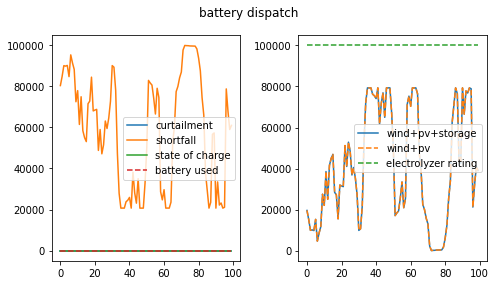

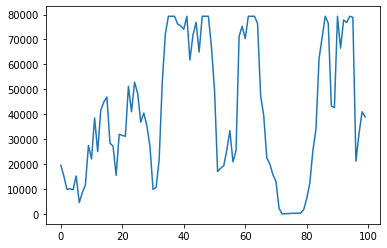

In [9]:
bat_model = SimpleDispatch()
bat_model.Nt = len(energy_shortfall_hopp)
bat_model.curtailment = combined_pv_wind_curtailment_hopp
bat_model.shortfall = energy_shortfall_hopp

bat_model.battery_storage = storage_size_mwh * 1000
bat_model.charge_rate = storage_size_mw * 1000
bat_model.discharge_rate = storage_size_mw * 1000

battery_used, excess_energy, battery_SOC = bat_model.run()
combined_pv_wind_storage_power_production_hopp = combined_pv_wind_power_production_hopp + battery_used

if plot_battery:
    plt.figure(figsize=(7,4))
    plt.subplot(121)
    plt.plot(combined_pv_wind_curtailment_hopp[200:300],label="curtailment")
    plt.plot(energy_shortfall_hopp[200:300],label="shortfall")
    plt.plot(battery_SOC[200:300],label="state of charge")
    # plt.ylim(0,350000)
    # plt.plot(excess_energy[200:300],label="excess")
    plt.plot(battery_used[200:300],"--",label="battery used")
    plt.legend()

    plt.subplot(122)
    plt.plot(combined_pv_wind_storage_power_production_hopp[200:300],label="wind+pv+storage")
    plt.plot(combined_pv_wind_power_production_hopp[200:300],"--",label="wind+pv")
    plt.plot(load[200:300],"--",label="electrolyzer rating")
    # plt.ylim(0,225000)

    plt.legend()
    plt.suptitle("battery dispatch")
    plt.tight_layout()

    plt.show()

if plot_grid:
    plt.plot(combined_pv_wind_storage_power_production_hopp[200:300],label="before buy from grid")

sell_price = 0.01
buy_price = 0.05

# sell_price = False
# buy_price = False

if sell_price:
    profit_from_selling_to_grid = np.sum(excess_energy)*sell_price
else:
    profit_from_selling_to_grid = 0.0

# buy_price = False # if you want to force no buy from grid
if buy_price:
    cost_to_buy_from_grid = 0.0

    for i in range(len(combined_pv_wind_storage_power_production_hopp)):
        if combined_pv_wind_storage_power_production_hopp[i] < kw_continuous:
            cost_to_buy_from_grid += (kw_continuous-combined_pv_wind_storage_power_production_hopp[i])*buy_price
            combined_pv_wind_storage_power_production_hopp[i] = kw_continuous
else:
    cost_to_buy_from_grid = 0.0

energy_to_electrolyzer = [x if x < kw_continuous else kw_continuous for x in combined_pv_wind_storage_power_production_hopp]



### Plot Dispatch Results

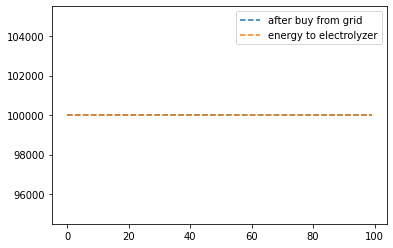

In [10]:

if plot_grid:
    plt.plot(combined_pv_wind_storage_power_production_hopp[200:300],"--",label="after buy from grid")
    plt.plot(energy_to_electrolyzer[200:300],"--",label="energy to electrolyzer")
    plt.legend()
    plt.show()



# Step 6: Run the Python H2A model

In [11]:
#TODO: Refactor H2A model call
# Should take as input (electrolyzer size, cost, electrical timeseries, total system electrical usage (kwh/kg),
# Should give as ouptut (h2 costs by net cap cost, levelized, total_unit_cost of hydrogen etc)   )

# electrical_generation_timeseries = combined_pv_wind_storage_power_production_hopp
electrical_generation_timeseries = np.zeros_like(energy_to_electrolyzer)
electrical_generation_timeseries[:] = energy_to_electrolyzer[:]

# Parangat model
adjusted_installed_cost = hybrid_plant.grid._financial_model.Outputs.adjusted_installed_cost
#NB: adjusted_installed_cost does NOT include the electrolyzer cost
useful_life = scenario['Useful Life']
net_capital_costs = 0

# intalled costs:
# hybrid_plant.grid._financial_model.costs

# system_rating = electrolyzer_size
system_rating = wind_size_mw + solar_size_mw
H2_Results, H2A_Results = run_h2_PEM.run_h2_PEM(electrical_generation_timeseries,electrolyzer_size,
                kw_continuous,forced_electrolyzer_cost,lcoe,adjusted_installed_cost,useful_life,
                net_capital_costs)

# TEMPORARY CORRECTION FOR PEM EFFICIENCY.
# # Convert H2 production from ~72.55kWh eff to 55.5kWh/kg
H2_Results['hydrogen_annual_output'] = H2_Results['hydrogen_annual_output'] * 72.55/55.5

### Plot H2 Results

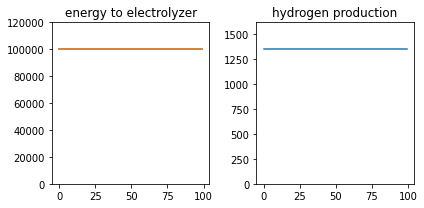

In [12]:
if plot_h2:
    hydrogen_hourly_production = H2_Results['hydrogen_hourly_production']
    plt.figure(figsize=(6,3))

    plt.subplot(121)
    plt.plot(electrical_generation_timeseries[200:300])
    plt.ylim(0,max(electrical_generation_timeseries[200:300])*1.2)
    plt.plot(load[200:300],label="electrolyzer rating")
    plt.title("energy to electrolyzer")

    plt.subplot(122)
    plt.plot(hydrogen_hourly_production[200:300])
    plt.ylim(0,max(hydrogen_hourly_production[200:300])*1.2)
    plt.title("hydrogen production")

    plt.tight_layout()
    plt.show()

# Step 6.5: Intermediate financial calculation

In [13]:
total_elec_production = np.sum(electrical_generation_timeseries) #REMOVE
total_hopp_installed_cost = hybrid_plant.grid._financial_model.SystemCosts.total_installed_cost
total_electrolyzer_cost = H2A_Results['scaled_total_installed_cost']
total_system_installed_cost = total_hopp_installed_cost + total_electrolyzer_cost
annual_operating_cost_hopp = (wind_size_mw * 1000 * 42) + (solar_size_mw * 1000 * 13)
annual_operating_cost_h2 = H2A_Results['Fixed O&M'] * H2_Results['hydrogen_annual_output']
total_annual_operating_costs = annual_operating_cost_hopp + annual_operating_cost_h2 + cost_to_buy_from_grid - profit_from_selling_to_grid
# h_lcoe_no_op_cost = lcoe_calc((H2_Results['hydrogen_annual_output']), total_system_installed_cost,
#                    0, 0.07, useful_life)

h_lcoe = lcoe_calc((H2_Results['hydrogen_annual_output']), total_system_installed_cost,
                    total_annual_operating_costs, 0.07, useful_life)

# Cashflow Financial Calculation (Not sure that this includes electrical prices)
discount_rate = scenario['Discount Rate']
cf_wind_annuals = hybrid_plant.wind._financial_model.Outputs.cf_annual_costs
cf_solar_annuals = hybrid_plant.pv._financial_model.Outputs.cf_annual_costs
cf_h2_annuals = H2A_Results['expenses_annual_cashflow'] # This might be unreliable. 
cf_df = pd.DataFrame([cf_wind_annuals, cf_solar_annuals, cf_h2_annuals[:len(cf_wind_annuals)]],['Wind', 'Solar', 'H2'])
# parent_path = os.path.abspath('')
# print(parent_path)
results_dir = parent_path + '/examples/H2_Analysis/results/'
cf_df.to_csv(os.path.join(results_dir, "Annual Cashflows_{}_{}_{}_discount_{}.csv".format(site_name, scenario_choice, atb_year, discount_rate)))

#NPVs of wind, solar, H2

npv_wind_costs = npf.npv(discount_rate, cf_wind_annuals)
npv_solar_costs = npf.npv(discount_rate, cf_solar_annuals)
npv_h2_costs = npf.npv(discount_rate, cf_h2_annuals)
npv_total_costs = npv_wind_costs+npv_solar_costs+npv_h2_costs
LCOH_cf_method = -npv_total_costs / (H2_Results['hydrogen_annual_output'] * useful_life)
financial_summary_df = pd.DataFrame([scenario['Useful Life'], scenario['Wind Cost KW'], scenario['Solar Cost KW'], forced_electrolyzer_cost,
                                        scenario['Debt Equity'], atb_year, ptc_avail, itc_avail,
                                        discount_rate, npv_wind_costs, npv_solar_costs, npv_h2_costs, LCOH_cf_method],
                                    ['Useful Life', 'Wind Cost KW', 'Solar Cost KW', 'Electrolyzer Cost KW', 'Debt Equity',
                                        'ATB Year', 'PTC available', 'ITC available', 'Discount Rate', 'NPV Wind Expenses', 'NPV Solar Expenses', 'NPV H2 Expenses', 'LCOH cf method'])
financial_summary_df.to_csv(os.path.join(results_dir, 'Financial Summary.csv'))

# Gut Check H2 calculation (non-levelized)
total_installed_and_operational_lifetime_cost = total_system_installed_cost + (30 * total_annual_operating_costs)
lifetime_h2_production = 30 * H2_Results['hydrogen_annual_output']
gut_check_h2_cost_kg = total_installed_and_operational_lifetime_cost / lifetime_h2_production

# Step 7: Print  Results

In [14]:
print_results = False
print_h2_results = True

if print_results:
    # ------------------------- #
    #TODO: Tidy up these print statements
    print("Future Scenario: {}".format(scenario['Scenario Name']))
    print("Wind Cost per KW: {}".format(scenario['Wind Cost KW']))
    print("PV Cost per KW: {}".format(scenario['Solar Cost KW']))
    print("Storage Cost per KW: {}".format(scenario['Storage Cost kW']))
    print("Storage Cost per KWh: {}".format(scenario['Storage Cost kWh']))
    print("Wind Size built: {}".format(wind_size_mw))
    print("PV Size built: {}".format(solar_size_mw))
    print("Storage Size built: {}".format(storage_size_mw))
    print("Storage Size built: {}".format(storage_size_mwh))
    print("Levelized cost of Electricity (HOPP): {}".format(lcoe))
    print("Total Yearly Electrical Output: {}".format(total_elec_production))
    print("Total Yearly Hydrogen Production: {}".format(H2_Results['hydrogen_annual_output']))
    print("Levelized Cost H2/kg (new method - no operational costs)".format(h_lcoe_no_op_cost))
    print("Capacity Factor of Electrolyzer: {}".format(H2_Results['cap_factor']))

if print_h2_results:
    print('Total Lifetime H2(kg) produced: {}'.format(lifetime_h2_production))
    print("Gut-check H2 cost/kg: {}".format(gut_check_h2_cost_kg))
    print("h_lcoe: ", h_lcoe)
    print("LCOH CF Method (doesn't include elec)", LCOH_cf_method)
    # print("Levelized cost of H2 (electricity feedstock) (HOPP): {}".format(
    #     H2_Results['feedstock_cost_h2_levelized_hopp']))
    # print("Levelized cost of H2 (excl. electricity) (H2A): {}".format(H2A_Results['Total Hydrogen Cost ($/kgH2)']))
    # print("Total unit cost of H2 ($/kg) : {}".format(H2_Results['total_unit_cost_of_hydrogen']))
    # print("kg H2 cost from net cap cost/lifetime h2 production (HOPP): {}".format(
    #     H2_Results['feedstock_cost_h2_via_net_cap_cost_lifetime_h2_hopp']))

Total Lifetime H2(kg) produced: 463727889.5742998
Gut-check H2 cost/kg: 2.841668304699136
h_lcoe:  3.1581532408856354
LCOH CF Method (doesn't include elec) 0.9366711973953259


# Step 8: Plot Results

In [15]:
matplotlib

Using matplotlib backend: <object object at 0x7fe8c1b63bc0>


# Step 9: Save Results

In [16]:
# Step 9: Plot HOPP Production, Curtailment, and Hydrogen Production Profiles
# ------------------------- #
#TODO: Place in function

save_outputs_dict['Site Name'].append(site_name)
save_outputs_dict['Scenario Choice'].append(scenario_choice)
save_outputs_dict['Site Lat'].append(lat)
save_outputs_dict['Site Lon'].append(lon)
save_outputs_dict['ATB Year'].append(atb_year)
save_outputs_dict['Resource Year'].append(year)
save_outputs_dict['Critical Load Factor'].append(critical_load_factor)
save_outputs_dict['kW continuous load'].append(kw_continuous)
save_outputs_dict['Useful Life'].append(useful_life)
save_outputs_dict['PTC'].append(ptc_avail)
save_outputs_dict['ITC'].append(itc_avail)
save_outputs_dict['Discount Rate'].append(discount_rate)
save_outputs_dict['Debt Equity'].append(debt_equity_split)
save_outputs_dict['Hub Height (m)'].append(tower_height)
save_outputs_dict['Storage Enabled'].append(storage_used)
save_outputs_dict['Wind Cost kW'].append(wind_cost_kw)
save_outputs_dict['Solar Cost kW'].append(solar_cost_kw)
save_outputs_dict['Storage Cost kW'].append(storage_cost_kw)
save_outputs_dict['Storage Cost kWh'].append(storage_cost_kwh)
save_outputs_dict['Storage Hours'].append(storage_hours)
save_outputs_dict['Wind MW built'].append(wind_size_mw)
save_outputs_dict['Solar MW built'].append(solar_size_mw)
save_outputs_dict['Storage MW built'].append(storage_size_mw)
save_outputs_dict['Storage MWh built'].append(storage_size_mwh)
save_outputs_dict['Battery Can Grid Charge'].append(battery_can_grid_charge)
save_outputs_dict['Built Interconnection Size'].append(hybrid_plant.interconnect_kw)
save_outputs_dict['Total Installed Cost $(HOPP)'].append(total_hopp_installed_cost)
save_outputs_dict['Total Yearly Electrical Output'].append(total_elec_production)
save_outputs_dict['LCOE'].append(lcoe)
save_outputs_dict['Total Annual H2 production (kg)'].append(H2_Results['hydrogen_annual_output'])
save_outputs_dict['Gut-Check Cost/kg H2 (non-levelized, includes elec if used)'].append(gut_check_h2_cost_kg)
save_outputs_dict['Levelized Cost/kg H2 (lcoe using installed and operation costs)'].append(h_lcoe)
save_outputs_dict['Levelized Cost/kg H2 (CF Method - using annual cashflows per technology)'].append(LCOH_cf_method)
save_outputs_dict['Grid Connected HOPP'].append(grid_connected_hopp)
save_outputs_dict['HOPP Total Generation'].append(np.sum(hybrid_plant.grid.generation_profile[0:8759]))
save_outputs_dict['Wind Capacity Factor'].append(hybrid_plant.wind._system_model.Outputs.capacity_factor)
save_outputs_dict['HOPP Energy Shortfall'].append(np.sum(energy_shortfall_hopp))
save_outputs_dict['HOPP Curtailment'].append(np.sum(combined_pv_wind_curtailment_hopp))
save_outputs_dict['Battery Generation'].append(np.sum(battery_used))
save_outputs_dict['Electricity to Grid'].append(np.sum(excess_energy))
save_outputs_dict['Electrolyzer Size'].append(H2A_Results['electrolyzer_size'])
save_outputs_dict['Electrolyzer Total System Size'].append(H2A_Results['total_plant_size'])
save_outputs_dict['H2A scaled total install cost'].append(H2A_Results['scaled_total_installed_cost'])
save_outputs_dict['H2A scaled total install cost per kw'].append(H2A_Results['scaled_total_installed_cost_kw'])


# save_all_runs = save_all_runs.append(save_outputs_dict, sort=False)
# Create dataframe from outputs and save
save_outputs = True
if save_outputs:
    save_outputs_dict_df = pd.DataFrame(save_outputs_dict)
    save_outputs_dict_df.to_csv(os.path.join(results_dir, "H2_Analysis_{}.csv".format('Main')))
    